In [1]:
import sys

sys.path.append("..")

import numpy as np
import torch
import random


from src.datasets import data, utils, configs
from torchvision import transforms as transforms

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
# Step 1: Create a diagonal dataset, to get valid latents
n_samples = 5000
n_slots = 2
default_cfg = configs.SpriteWorldConfig()
sample_mode = "diagonal"
no_overlap = True
delta = 0.125

diagonal_dataset = data.SpriteWorldDataset(
    n_samples,
    n_slots,
    default_cfg,
    sample_mode=sample_mode,
    no_overlap=no_overlap,
    delta=delta,
    transform=transforms.Compose(
    [transforms.ToPILImage(), transforms.ToTensor()])
)

Generating images (sampling: diagonal): 100%|█████████████████████████████████████| 5000/5000 [00:43<00:00, 113.96it/s]


In [3]:
# Step 2: Create a dataloader
scale = torch.FloatTensor(
    [rng.max - rng.min for rng in default_cfg.get_ranges().values()]
).reshape(1, 1, -1)
scale = torch.cat([scale[:, :, :-4], scale[:, :, -3:-2]], dim=-1)


min_offset = torch.FloatTensor(
    [rng.min for rng in default_cfg.get_ranges().values()]
).reshape(1, 1, -1)
min_offset = torch.cat([min_offset[:, :, :-4], min_offset[:, :, -3:-2]], dim=-1)

batch_size = 128
loader = torch.utils.data.DataLoader(
    diagonal_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda b: utils.collate_fn_normalizer(b, min_offset, scale),
)

In [4]:
# Step 3: Make a permutation for every batch and create permuted dataset
perms = []
batch_len_accum = 0
for _, true_latents in loader:
    batch_len = true_latents.shape[0]
    perm = torch.randperm(batch_len) + batch_len_accum
    perms.append(perm)
    batch_len_accum += batch_len

perms_concated = torch.cat(perms)

permuted_latents = torch.cat([diagonal_dataset.z[:, 0].unsqueeze(1), diagonal_dataset.z[perms_concated, 1].unsqueeze(1)], dim=1)

permuted_dataset = data.SpriteWorldDataset(
    n_samples,
    n_slots,
    default_cfg,
    sample_mode=sample_mode,
    no_overlap=no_overlap,
    delta=delta,
    z=permuted_latents,
    transform=transforms.Compose(
    [transforms.ToPILImage(), transforms.ToTensor()])

)

permuted_dataloader = torch.utils.data.DataLoader(
    permuted_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda b: utils.collate_fn_normalizer(b, min_offset, scale),
)

Generating images (sampling: diagonal): 100%|█████████████████████████████████████| 5000/5000 [00:40<00:00, 124.10it/s]


In [5]:
# Step 4: Load the model
from src.models import base_models

checkpoint_path = "D:/git_projects/bethgelab/lab_rotation/object_centric_ood/notebooks/models/Supervised, diagonal, 2 objects/SlotMLPAdditive_2023-06-15_16-36-39_last_train_model_diagonal_2023_checkpoint.pt"
checkpoint = torch.load(checkpoint_path)

model = model = base_models.SlotMLPAdditive(3, 2, 5)


model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

SlotMLPAdditive(
  (encoder): SlotEncoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ELU(alpha=1.0)
      (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ELU(alpha=1.0)
      (6): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ELU(alpha=1.0)
      (8): View()
      (9): Linear(in_features=512, out_features=256, bias=True)
      (10): ELU(alpha=1.0)
      (11): Linear(in_features=256, out_features=256, bias=True)
      (12): ELU(alpha=1.0)
      (13): Linear(in_features=256, out_features=128, bias=True)
      (14): ELU(alpha=1.0)
      (15): Linear(in_features=128, out_features=10, bias=True)
    )
  )
  (decoder): SlotMLPAdditiveDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=5, out_features=256, bias=True)
      (1): ELU(alpha=1.0)


In [6]:
# Step 5: Get the latents for the original dataset and reshuffle them
from src.metrics import hungarian_slots_loss

latents = []
with torch.no_grad():
    for images, true_latents in loader:
        true_figures = images[:, :-1, ...]
        images = images[:, -1, ...].squeeze(1)

        output = model(images)
        predicted_figures = output["reconstructed_figures"]
        
        figures_reshaped = true_figures.view(true_figures.shape[0], true_figures.shape[1], -1)

        predicted_figures = predicted_figures.permute(1, 0, 2, 3, 4)
        predicted_figures_reshaped = predicted_figures.reshape(
            predicted_figures.shape[0], predicted_figures.shape[1], -1
        )

        _, indexes = hungarian_slots_loss(figures_reshaped, predicted_figures_reshaped)
        
        indexes = torch.LongTensor(indexes)
        predicted_latents = output["predicted_latents"].detach().cpu()
        true_latents = true_latents.detach().cpu()

        # shuffling predicted latents to match true latents
        predicted_latents = predicted_latents.gather(
            1,
            indexes[:, :, 1].unsqueeze(-1).expand(-1, -1, true_latents.shape[-1]),
        )
        latents.append(predicted_latents)

latents = torch.cat(latents)
# after this point we had z_hat matched to original, not permuted z

In [89]:
for images, true_latents in loader:
    break

In [99]:
temp_image_true, temp_figures_true = model.decoder(true_latents[2].unsqueeze(0))

In [100]:
temp_image, temp_figures = model.decoder(latents[2].unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


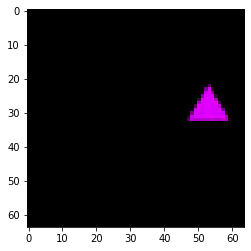

In [103]:
plt.imshow(temp_figures_true.squeeze()[1].squeeze().permute(1, 2, 0).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


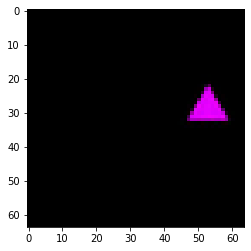

In [104]:
plt.imshow(temp_figures.squeeze()[1].squeeze().permute(1, 2, 0).detach().numpy())

In [7]:
# Step 6: Permute predicted latents, and compare with permuted dataset
latents = torch.cat([latents[:, 0].unsqueeze(1), latents[perms_concated, 1].unsqueeze(1)], dim=1)

In [14]:
# Step 6: continued
mse = 0
batch_size_accum = 0
with torch.no_grad():
    for permuted_images, permuted_latents in permuted_dataloader:
        true_figures = permuted_images[:, :-1, ...]
        permuted_images = permuted_images[:, -1, ...].squeeze(1)
        
        imagined_images, _ = model.decoder(
            latents[batch_size_accum : batch_size_accum + len(permuted_images)]
        )
        
        batch_size_accum += len(permuted_images)
        # compare reconstructed images with imagined images

        mse += ((permuted_images - imagined_images) ** 2).sum() / len(permuted_dataset)

In [15]:
mse

tensor(2.0411)

In [27]:
imagined_images.shape

torch.Size([8, 3, 64, 64])

In [10]:
import matplotlib.pyplot as plt

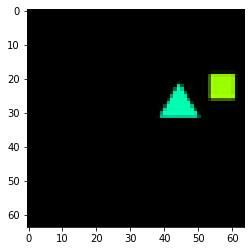

In [11]:
plt.imshow(permuted_images[1].permute(1, 2, 0))

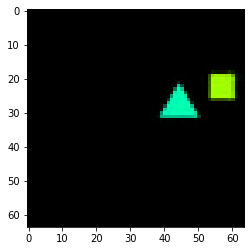

In [12]:
plt.imshow(imagined_images.clip(0, 1)[1].permute(1, 2, 0))

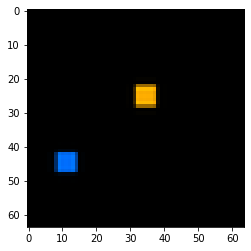

In [42]:
plt.imshow(permuted_dataset[0][0][-1].permute(1, 2, 0))

In [40]:
torch.cat([diagonal_dataset.z[:, 0].unsqueeze(1), diagonal_dataset.z[perms_concated, 1].unsqueeze(1)], dim=1)

torch.Size([5000, 2, 8])

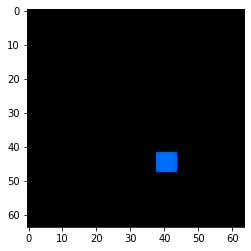

In [24]:
plt.imshow(permuted_dataset.x[0][0].permute(1, 2, 0))

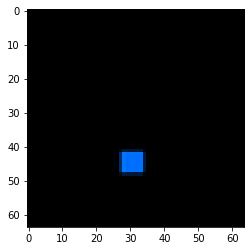

In [25]:
plt.imshow(diagonal_dataset.x[0][0].permute(1, 2, 0))